In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Read input data
gen_cor = pd.read_csv('gen_cor.csv')
obs_cor = pd.read_csv('obs_cor.csv')

inputs = gen_cor.merge(obs_cor, on=['trait1', 'trait2']).drop_duplicates()

In [3]:
# Check that we have each pair twice ([x, y] and [y, x]) for merge with directed graph
edges = [[row.trait1, row.trait2] for i, row in inputs.iterrows()]
reverse_check = [edge[::-1] in edges for edge in edges]
assert sum(reverse_check) == len(inputs)

In [4]:
# Read target data
edges = pd.read_csv('../../data/processed/mr-eve-edgelist.csv')
X_y = inputs.merge(edges, left_on=['trait1', 'trait2'], right_on=['head_node', 'tail_node']).drop_duplicates()
del edges

# Save merged edgelist for embedding 
out = X_y[['head_node', 'tail_node', 'neglog_pval', 'abs_effect']].drop_duplicates()
out.to_csv('MR_obscor_gencor_edgelist.csv', index=False)

In [5]:
# Prepare X and y dataframes
X_corr = X_y[['rg', 'cor']]
y_effect = X_y['abs_effect']
y_pval = X_y['neglog_pval']

# Regress absolute effect size

In [6]:
# Fit model on effect size edge weights
effect_model = LinearRegression().fit(X_corr, y_effect)
effect_r2 = effect_model.score(X_corr, y_effect)
print(f'Regression of absolute effect on genetic and observational correlation.')
print(f'R2 = {effect_r2}')

Regression of absolute effect on genetic and observational correlation.
R2 = 0.40215010670701856


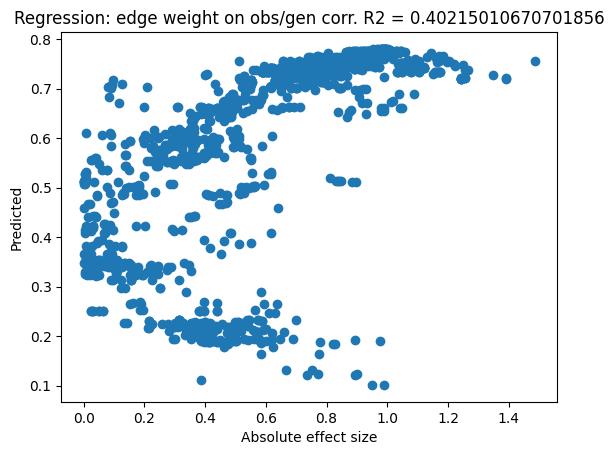

In [7]:
# Plot fitted values against actual weights
plt.scatter(y_effect, effect_model.predict(X_corr))
plt.title(f'Regression: edge weight on obs/gen corr. R2 = {effect_r2}')
plt.ylabel('Predicted')
plt.xlabel('Absolute effect size')
plt.show()

In [8]:
# Now include best embeddings in regression
effect_embeds = pd.read_csv('effect_best_embeds.edgevectors', skiprows=1, header=None).dropna(how='all', axis='columns')
X_y_effect = X_y.merge(effect_embeds, left_on=['trait1', 'trait2'], right_on=[0, 1])
X_cols = ['rg', 'cor'] + [i for i in range(3, len(effect_embeds.columns)+1)]
X_effect = X_y_effect[X_cols]


effect_embed_model = LinearRegression().fit(X_effect, y_effect)
effect_embed_r2 = effect_embed_model.score(X_effect, y_effect)
print(f'Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.')
print(f'R2 = {effect_embed_r2}')


Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.
R2 = 0.7035946546418346


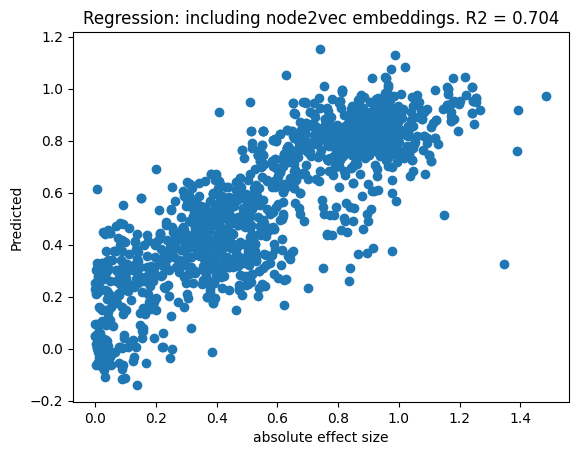

In [9]:
plt.scatter(y_effect, effect_embed_model.predict(X_effect))
plt.title(f'Regression: including node2vec embeddings. R2 = {round(effect_embed_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('absolute effect size')
plt.show()

# Regress -log(pval) 

In [10]:
# Fit model on pval edge weights
pval_model = LinearRegression().fit(X_corr, y_pval)
pval_r2 = pval_model.score(X_corr, y_pval)
print(f'Regression of -log10(pval) on genetic and observational correlation.')
print(f'R2 = {pval_r2}')

Regression of -log10(pval) on genetic and observational correlation.
R2 = 0.5788689686382369


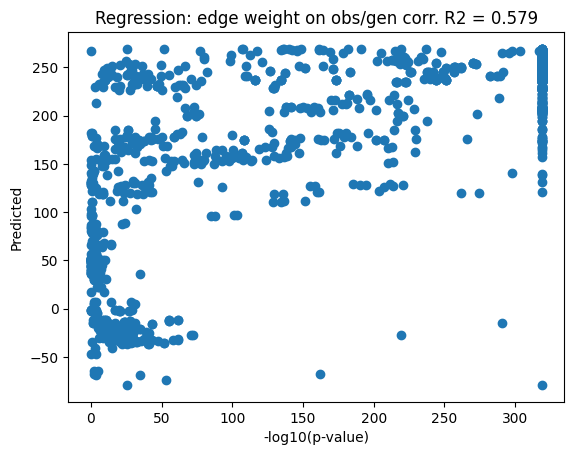

In [11]:
plt.scatter(y_pval, pval_model.predict(X_corr))
plt.title(f'Regression: edge weight on obs/gen corr. R2 = {round(pval_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('-log10(p-value)')
plt.show()

In [12]:
pval_embeds = pd.read_csv('pval_best_embeds.edgevectors', skiprows=1, header=None).dropna(how='all', axis='columns')
X_y_pval = X_y.merge(pval_embeds, left_on=['trait1', 'trait2'], right_on=[0, 1])
X_cols = ['rg', 'cor'] + [i for i in range(3, len(pval_embeds.columns)+1)]
X_pval = X_y_pval[X_cols]


pval_embed_model = LinearRegression().fit(X_pval, y_pval)
pval_embed_r2 = pval_embed_model.score(X_pval, y_pval)
print(f'Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.')
print(f'R2 = {pval_embed_r2}')

Regression of absolute effect on genetic and observational correlation AND node2vec embeddings.
R2 = 0.7304584009470649


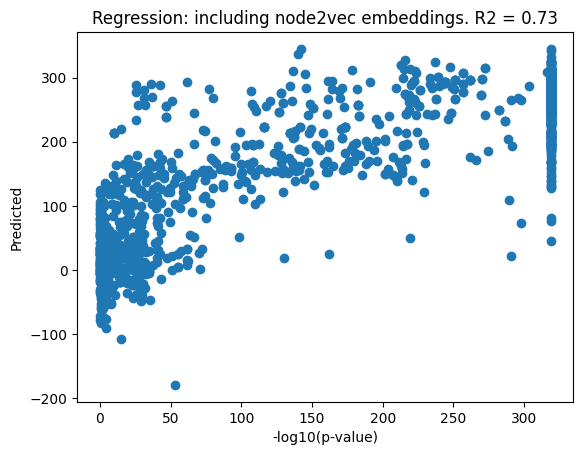

In [13]:
plt.scatter(y_pval, pval_embed_model.predict(X_pval))
plt.title(f'Regression: including node2vec embeddings. R2 = {round(pval_embed_r2, 3)}')
plt.ylabel('Predicted')
plt.xlabel('-log10(p-value)')
plt.show()